# Setup

In [85]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm

In [252]:
procs_added = pd.read_csv("procs_added.txt", index_col=None, names=["tick", "machineID", "procType", "sla", "actualComp", "migrated"])
procs_current = pd.read_csv("procs_current.txt", index_col=None, names=["tick", "machineID", "sla", "actualComp", "compDone"])
procs_done = pd.read_csv("procs_done.txt", index_col=None, names=["tick", "machineID", "procType", "sla", "ticksPassed", "actualComp", "isLate"])
procs_killed = pd.read_csv("procs_killed.txt", index_col=None, names=["tick", "machineID", "sla", "compDone", "memUsed"])

sched_decisions = pd.read_csv("sched.txt", index_col=None, names=["tick", "machineID", "sla", "compDone", "ticksPassed", "ticksGiven", "done"])
machine_changes = pd.read_csv("machines.txt", index_col=None, names=["areAdding", "tick", "machineID", "memUsage", "totalProcs", "procsKilled"])
usage_stats = pd.read_csv("usage.txt", index_col=None, names=['tick', 'machineID', 'machineIsActive', 'unusedTicks', 'memUsage'])

# Overview takeaways

In [254]:
# procs late
# I am only looking at true negatives, ie where it would have been possible to finish the proc within the SLA
procs_late = procs_done.where(procs_done["ticksPassed"] > procs_done["sla"]).dropna().reset_index(drop=True)
procs_late = procs_late.where(procs_late["ticksPassed"] > procs_late["actualComp"]).dropna().reset_index(drop=True)
procs_late['amountLate'] = procs_late["ticksPassed"] - procs_late["sla"]
avg_amount_late = procs_late['amountLate'].mean()
num_procs_late = procs_late.shape[0]
print("procs late: " + str(num_procs_late))
print("avg amount late: " + str(avg_amount_late))

# procs killed
num_procs_killed = procs_killed.shape[0]
print("procs killed: " + str(num_procs_killed))

# avg usage
active_machines_usage = usage_stats.where(usage_stats['machineIsActive'] == 1)
avg_mem_usg = active_machines_usage['memUsage'].mean()
print("avg mem usage: " + str(avg_mem_usg))
avg_unused_ticks = active_machines_usage['unusedTicks'].mean()
print("avg unused ticks: " + str(avg_unused_ticks))

procs late: 874
avg amount late: 1.1556744233132148
procs killed: 0
avg mem usage: 0.09725999999999999
avg unused ticks: 0.025725


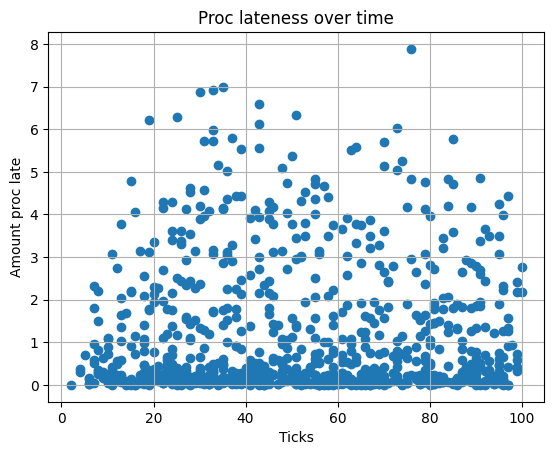

In [255]:
# plot by tick
plt.scatter(procs_late["tick"], procs_late['amountLate'].values)
plt.xlabel('Ticks')
plt.ylabel('Amount proc late')
plt.title('Proc lateness over time')
plt.grid(True)
plt.show()

# Procs late overview

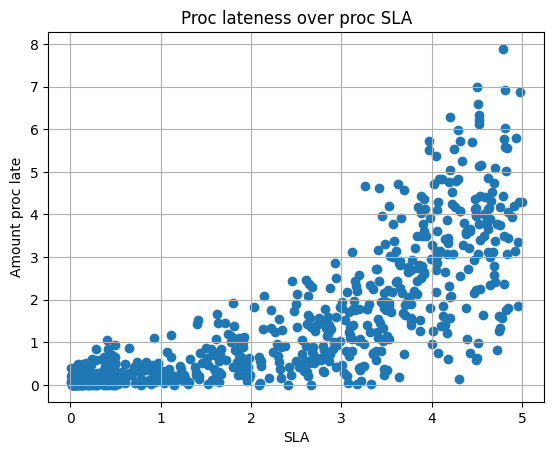

In [256]:
# plot by SLA
plt.scatter(procs_late["sla"], procs_late['amountLate'].values)
plt.xlabel('SLA')
plt.ylabel('Amount proc late')
plt.title('Proc lateness over proc SLA')
plt.grid(True)
plt.show()

# Procs killed overview

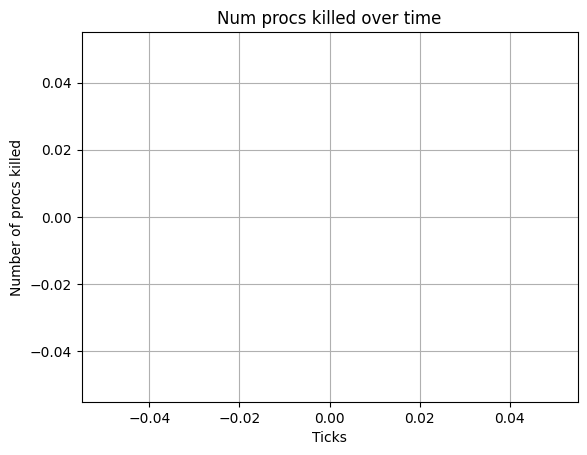

In [257]:
# plot by tick
ticks_procs_killed = procs_killed[["tick"]].groupby("tick").size().reset_index(name='counts')
ticks_procs_killed

plt.scatter(ticks_procs_killed["tick"], ticks_procs_killed['counts'].values)
plt.xlabel('Ticks')
plt.ylabel('Number of procs killed')
plt.title('Num procs killed over time')
plt.grid(True)
plt.show()

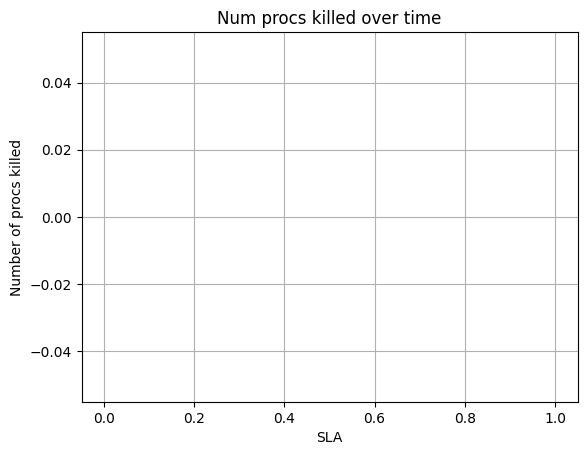

In [258]:
# plot by SLA
plt.hist(procs_killed["sla"], bins=20)
plt.xlabel('SLA')
plt.ylabel('Number of procs killed')
plt.title('Num procs killed over time')
plt.grid(True)
plt.show()

# Utilization Overview

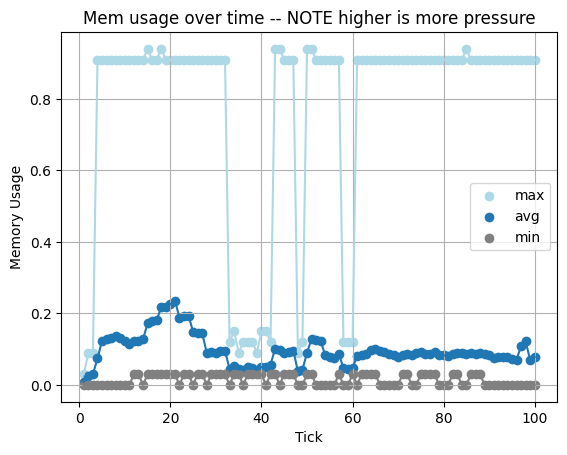

In [259]:
# plot memory usage over time
grouped_mean = active_machines_usage.groupby('tick')["memUsage"].mean().reset_index()
grouped_min = active_machines_usage.groupby('tick')["memUsage"].min().reset_index()
grouped_max = active_machines_usage.groupby('tick')["memUsage"].max().reset_index()

plt.scatter(grouped_max["tick"], grouped_max["memUsage"], color='lightblue', label="max")
plt.plot(grouped_max["tick"], grouped_max["memUsage"], color='lightblue')
plt.scatter(grouped_mean["tick"], grouped_mean["memUsage"], label="avg")
plt.plot(grouped_mean["tick"], grouped_mean["memUsage"])
plt.scatter(grouped_min["tick"], grouped_min["memUsage"], color='grey', label="min")
plt.plot(grouped_min["tick"], grouped_min["memUsage"], color='grey')
plt.xlabel('Tick')
plt.ylabel('Memory Usage')
plt.title('Mem usage over time -- NOTE higher is more pressure')
plt.grid(True)
plt.legend()
plt.show()

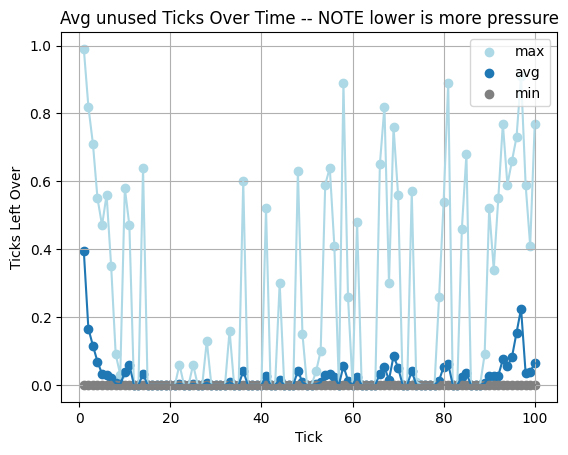

In [260]:
# plot ticks left over, over time
grouped_min = active_machines_usage.groupby('tick')["unusedTicks"].min().reset_index()
grouped_mean = active_machines_usage.groupby('tick')["unusedTicks"].mean().reset_index()
grouped_max = active_machines_usage.groupby('tick')["unusedTicks"].max().reset_index()
# grouped["tick"]
plt.scatter(grouped_max["tick"], grouped_max["unusedTicks"], color='lightblue', label="max")
plt.plot(grouped_max["tick"], grouped_max["unusedTicks"], color='lightblue')
plt.scatter(grouped_mean["tick"], grouped_mean["unusedTicks"], label="avg")
plt.plot(grouped_mean["tick"], grouped_mean["unusedTicks"])
plt.scatter(grouped_min["tick"], grouped_min["unusedTicks"], color='grey', label="min")
plt.plot(grouped_min["tick"], grouped_min["unusedTicks"], color='grey')
plt.xlabel('Tick')
plt.ylabel('Ticks Left Over')
plt.title('Avg unused Ticks Over Time -- NOTE lower is more pressure')
plt.grid(True)
plt.legend()
plt.show()

# Procs late

In [261]:
procs_late.where(procs_late['amountLate'] > 80).dropna()

,tick,machineID,procType,sla,ticksPassed,actualComp,isLate,amountLate


### Per machine

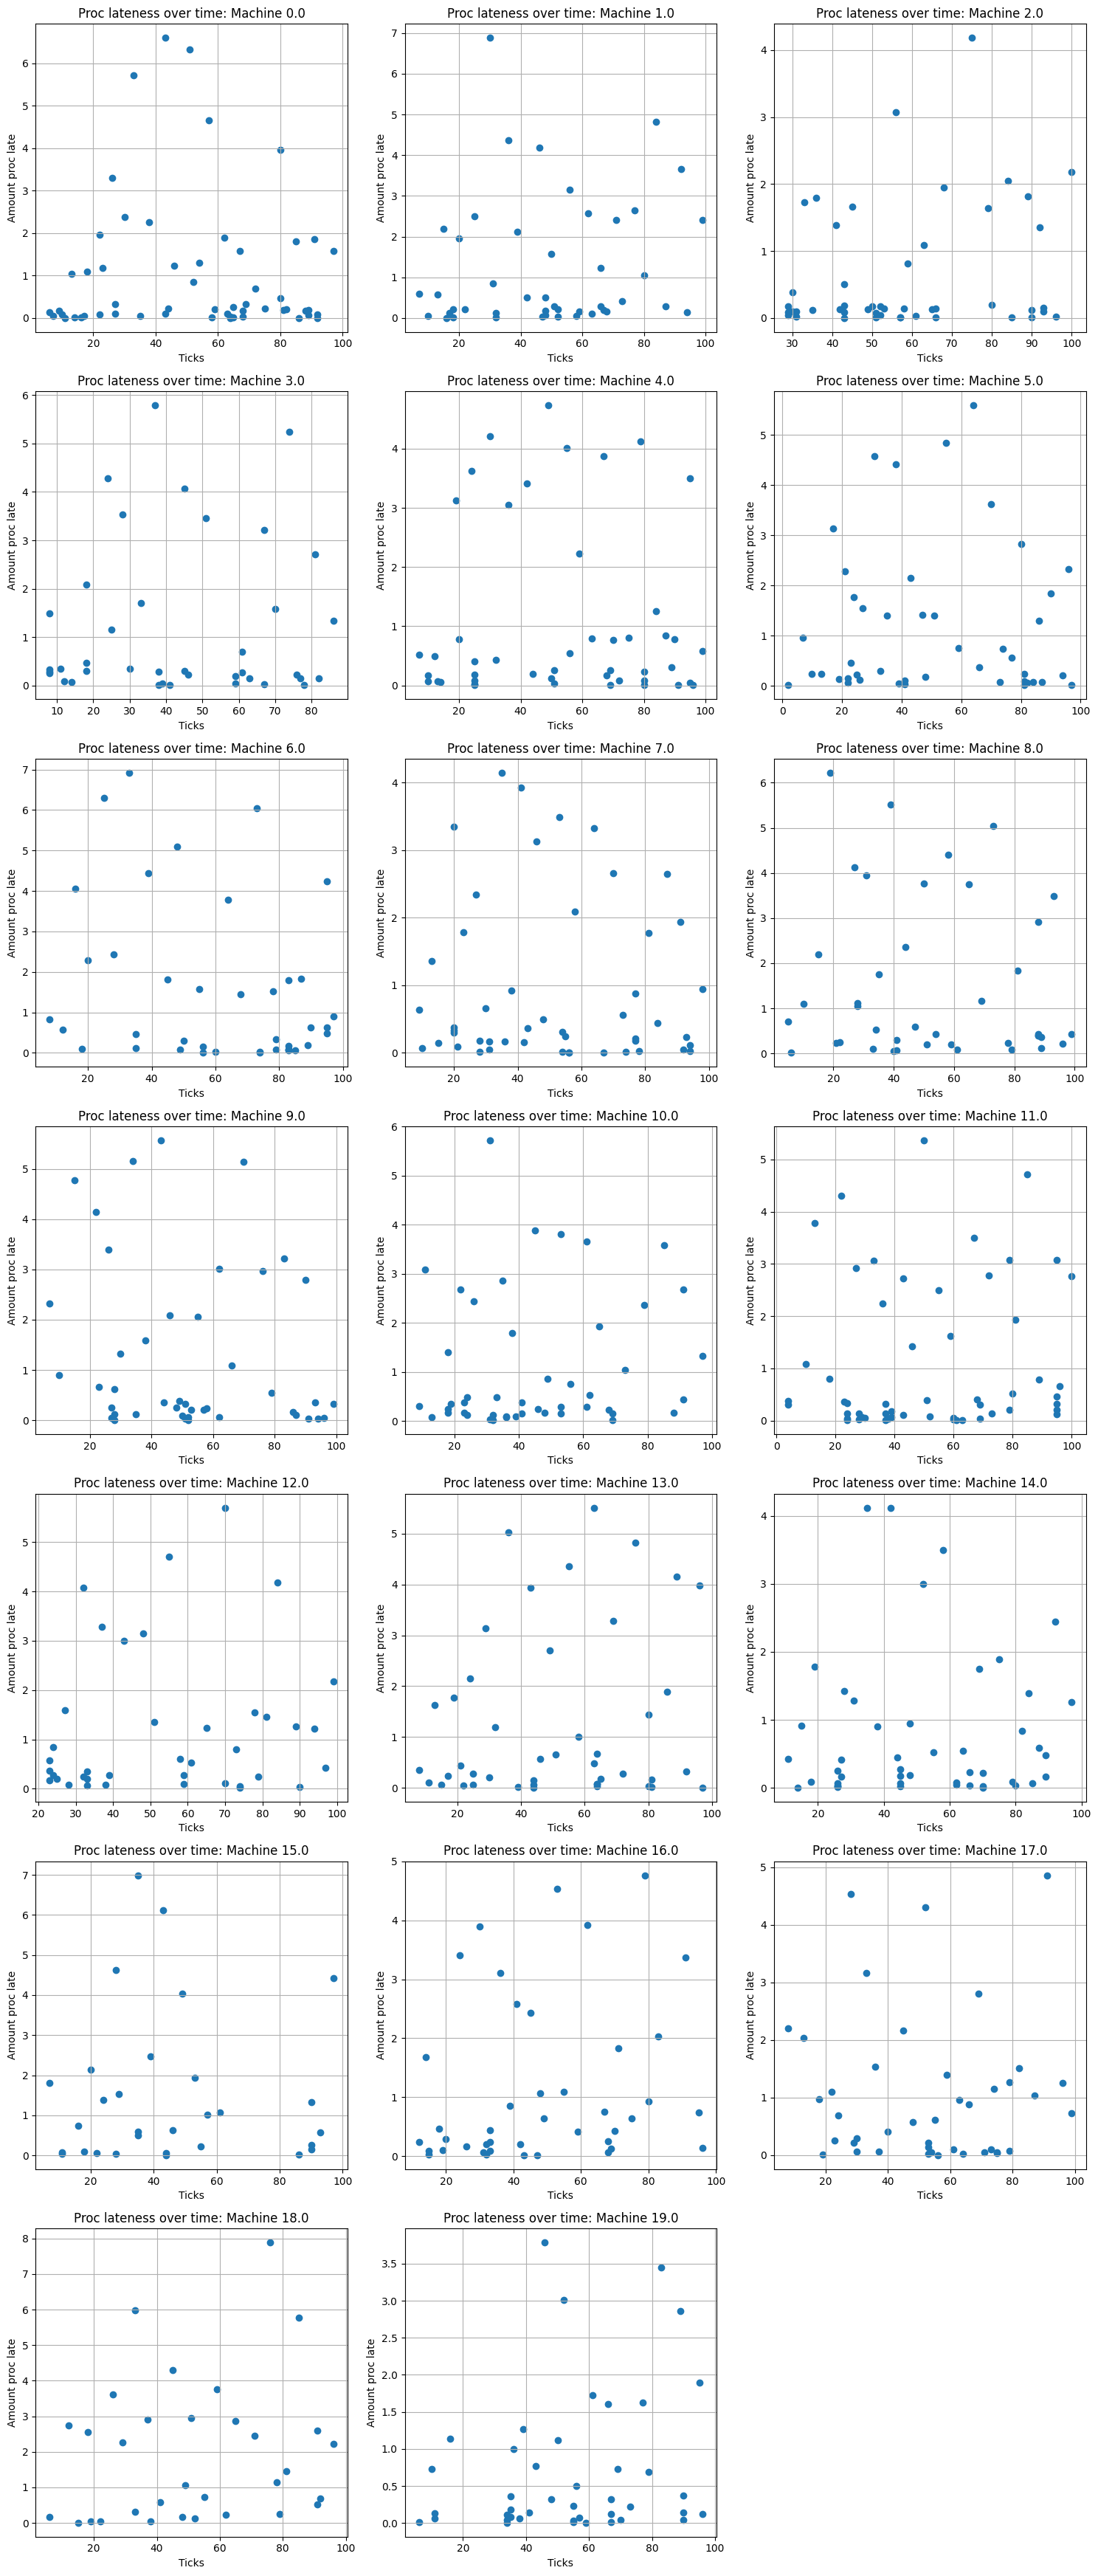

In [262]:
procs_late = procs_late.sort_values('machineID')
unique_ids = procs_late['machineID'].unique()

# Set up subplots
num_plots = len(unique_ids)
num_cols = 3  # Adjust as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

# Plot each machine's data
for i, id_ in enumerate(unique_ids):
    ax = axes[i]
    data = procs_late.where((procs_late['machineID']==id_)).dropna().reset_index(drop=True)
    ax.scatter(data["tick"], data['amountLate'].values)
    ax.set_title(f'Proc lateness over time: Machine {id_}')
    ax.set_xlabel('Ticks')
    ax.set_ylabel('Amount proc late')
    ax.grid(True)

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Procs killed

### Per machine

In [ ]:
unique_ids = procs_killed['machineID'].unique()

# Set up subplots
num_plots = len(unique_ids)
num_cols = 3  # Adjust as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

# Plot each machine's data
for i, id_ in enumerate(unique_ids):
    ax = axes[i]

    procs_killed_here = procs_killed.where((procs_killed['machineID']==id_)).dropna().reset_index(drop=True)
    ticks_procs_killed_here = procs_killed_here[["tick"]].groupby("tick").size().reset_index(name='counts')

    ax.scatter(ticks_procs_killed_here["tick"], ticks_procs_killed_here['counts'].values)
    ax.set_title(f'Procs killed over time: Machine {id_}')
    ax.set_xlabel('Ticks')
    ax.set_ylabel('Number procs killed')
    # ax.set_grid(True)

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# To understand LB decisions

## Procs being added

In [263]:
tick = 37


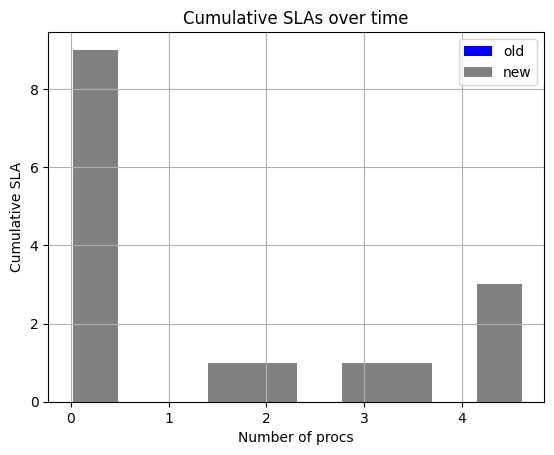

In [264]:
# CDF of all procs added (NOTE this includes all procs that are being recycled because they were killed)
cdf=pd.DataFrame()
cdf['sla'] = procs_added.where((procs_added['tick']==tick))['sla'].dropna()#.cumsum()
cdf['migrated'] = procs_added.where(procs_added['tick'] == tick)['migrated'].dropna()

# Split the DataFrame based on the "isNew" column
migrated_procs = cdf.where(cdf['migrated'] == 1).dropna()
brand_new_procs = cdf.where(cdf['migrated'] == 0).dropna()

# Plotting
plt.hist(migrated_procs['sla'].values, bins=70, color='blue', label='old')
plt.hist(brand_new_procs['sla'].values, color='grey', label='new')
plt.xlabel('Number of procs')
plt.ylabel('Cumulative SLA')
plt.title('Cumulative SLAs over time')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# the above function but for all ticks
unique_ids = procs_added['tick'].unique()

# Set up subplots
num_plots = len(unique_ids)
num_cols = 3  # Adjust as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

for i, tick_ in enumerate(unique_ids):
    ax = axes[i]
    cdf = procs_added.where((procs_added['tick']==tick_))[['sla', 'machineID']].dropna().sort_index().reset_index(drop=True).cumsum()

    ax.plot(cdf.index, cdf['sla'].values, marker='o', linestyle='-')
    ax.set_xlabel('Number of procs')
    ax.set_ylabel('Cumulative SLA')
    ax.set_title('Cumulative SLAs over time')
    # plt.grid(True)

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Where they're being added to

### Overview of machines existing states

In [266]:
procs_tick_current = procs_current.where((procs_current['tick']==tick))[['machineID', 'sla', 'compDone']].dropna().sort_values('machineID')
procs_tick_current['diffToSla'] = procs_tick_current['sla'] - procs_tick_current['compDone']
tick

37

In [ ]:
# CDFs of all the procs currently on each machine (looking at diffToSLA)
# unique_ids = procs_tick_current['machineID'].unique()

# # Set up subplots
# num_plots = len(unique_ids)
# num_cols = 3  # Adjust as needed
# num_rows = -(-num_plots // num_cols)  # Ceiling division

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
# if num_rows > 1 and num_cols > 1:
#     axes = axes.flatten()

# # Plot each machine's data
# for i, id_ in enumerate(unique_ids):
#     ax = axes[i]
#     data = procs_tick_current.where((procs_tick_current['machineID']==id_))["diffToSla"].dropna().reset_index(drop=True)
#     ax.plot(data.index, data.cumsum().values, marker='o', linestyle='-')
#     ax.set_title(f'Machine {id_}')
#     ax.set_xlabel('Number of procs')
#     ax.set_ylabel('Cum Sum SLA')

# # If there are unused subplots, hide them
# for i in range(len(unique_ids), num_rows * num_cols):
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

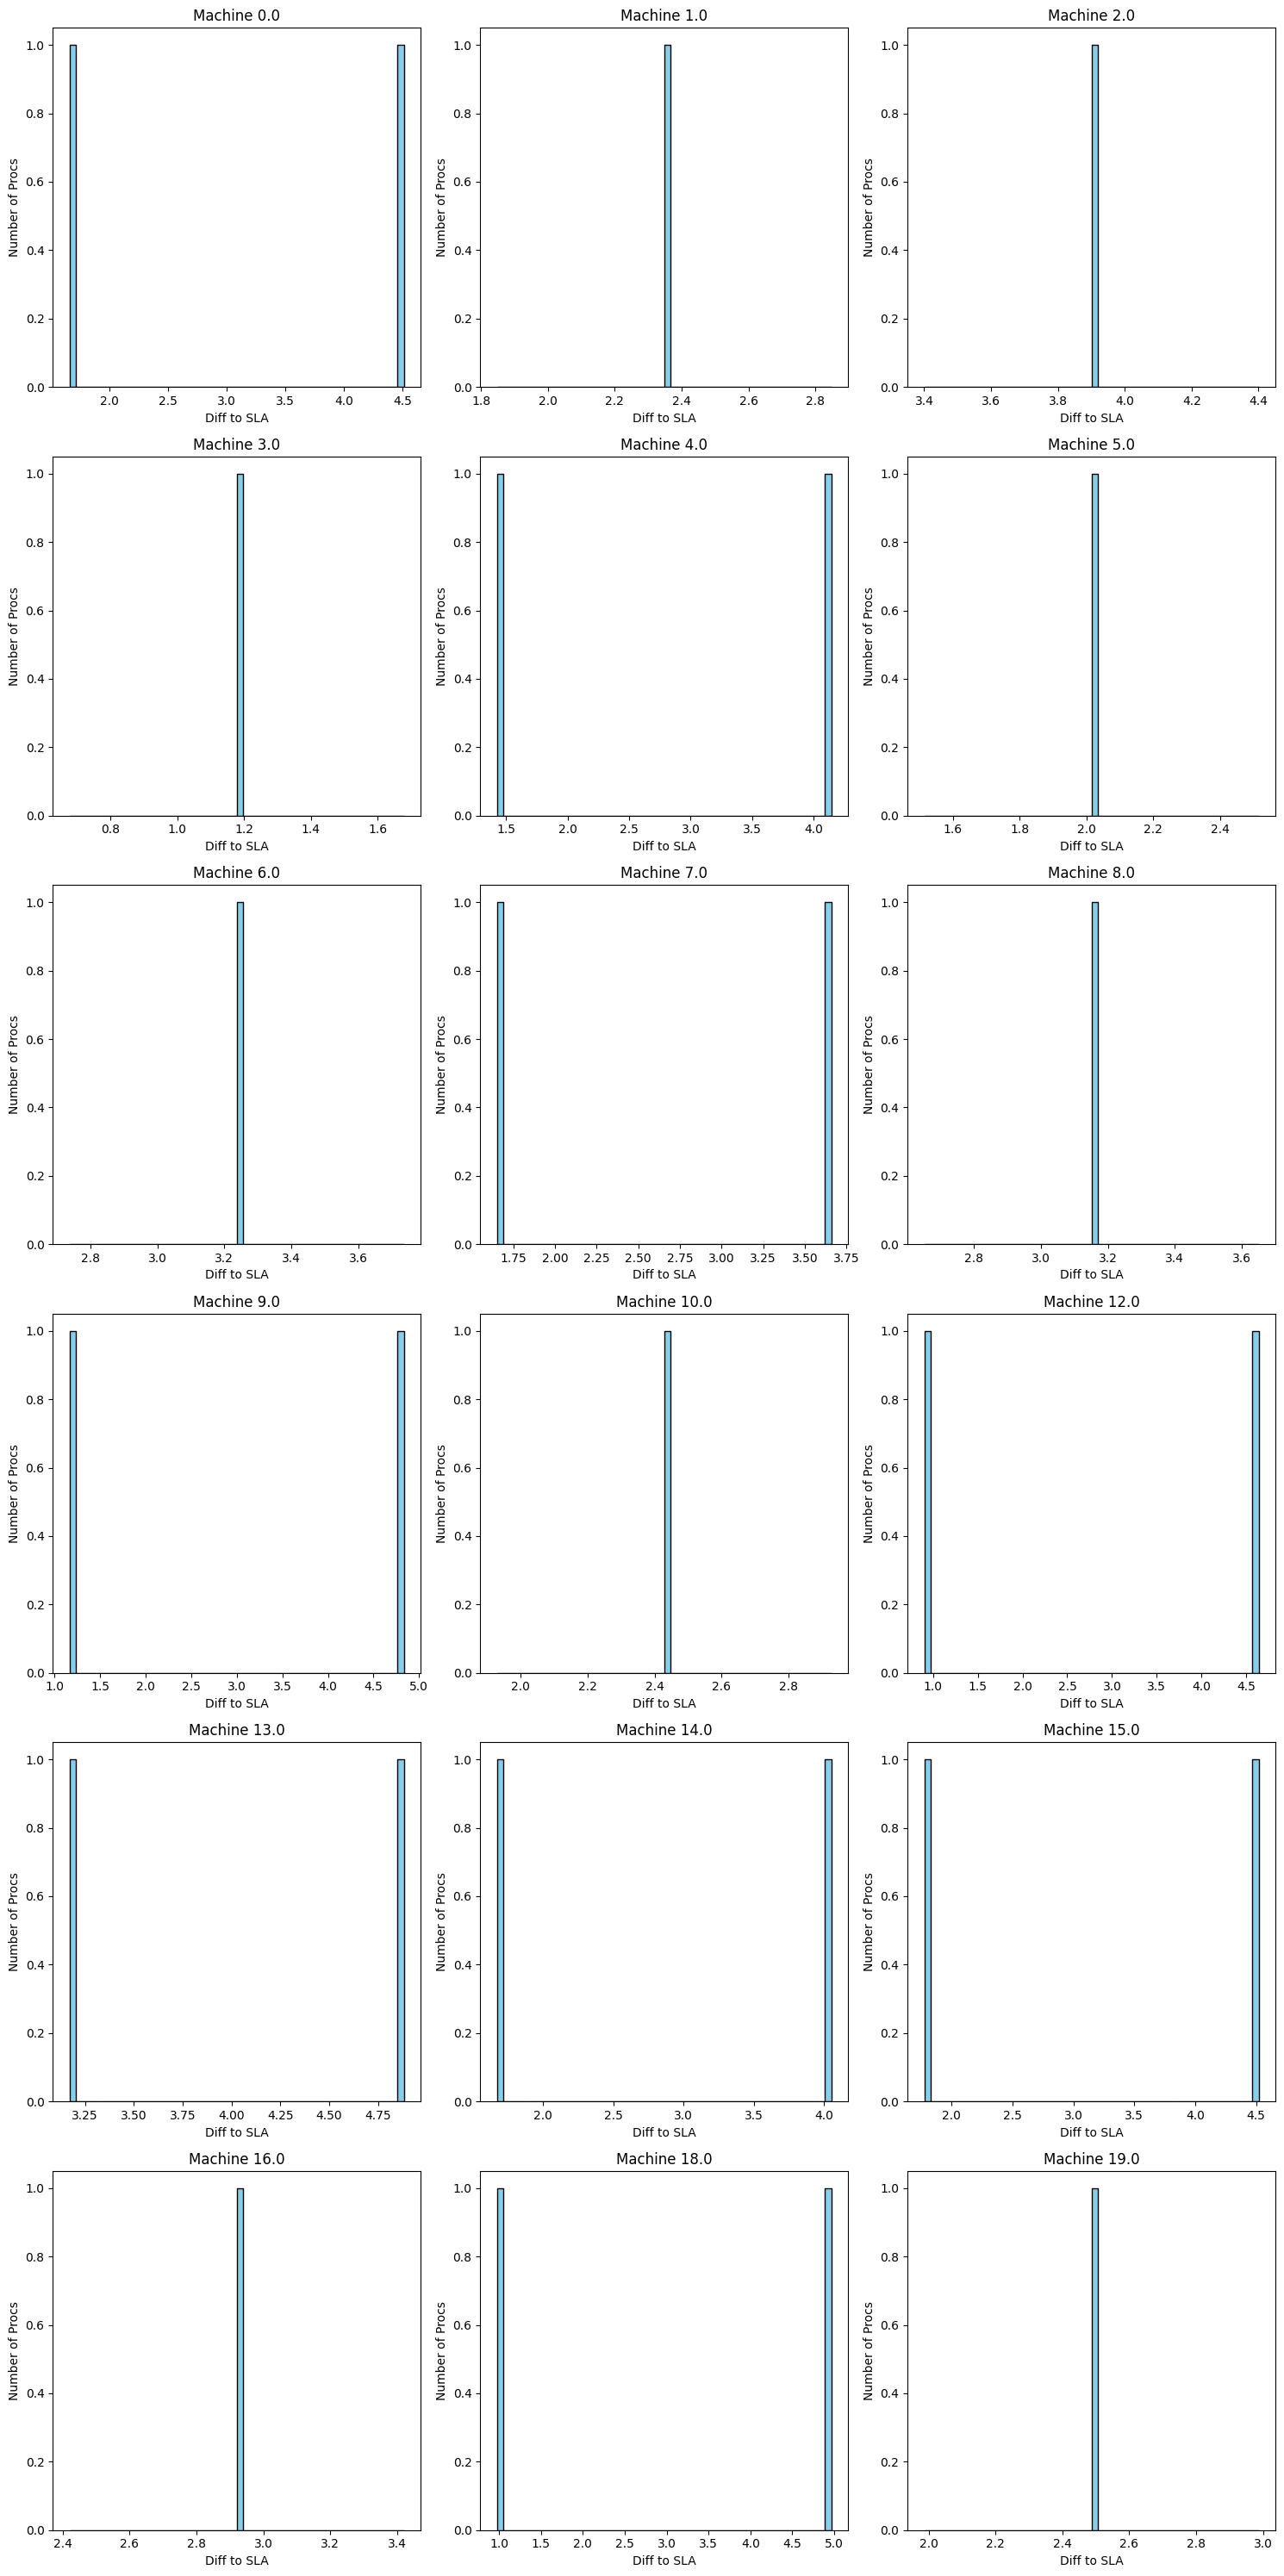

In [269]:
# histogram of all the procs currenlty on each machine -- and the ones being added
unique_ids = procs_tick_current['machineID'].unique()
num_plots = len(unique_ids)
num_cols = 3  # Adjust as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

# Plot each id's data
for i, id_ in enumerate(unique_ids):
    ax = axes[i]
    curr_procs = procs_tick_current.where((procs_tick_current['machineID']==id_)).dropna()
    # this is for if we want to use the buckets that I use in the code to determine where to put procs
    # base_vals = pd.DataFrame()
    # base_vals['base'] = np.power(2, np.floor(np.log(slas['sla'])/np.log(2))).reset_index(drop=True)
    
    ax.hist(curr_procs['diffToSla'], bins=50, color='skyblue', edgecolor='black')
    ax.set_title(f'Machine {id_}')
    ax.set_xlabel('Diff to SLA')
    ax.set_ylabel('Number of Procs')

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Machines the new procs were added to

In [270]:
# look at state after new procs: where ae they being added
procs_tick_added = procs_added.where((procs_added['tick']==tick))[['machineID', 'sla']].dropna().reset_index(drop=True)
procs_tick_added = procs_tick_added.rename(columns={"sla":"diffToSla", "machineID": "machineID"})
# total_procs = procs_tick_current[['machineID', 'diffToSla', 'compDone']].append(procs_tick_added)
total_procs = pd.concat([procs_tick_current[['machineID', 'diffToSla', 'compDone']], procs_tick_added])
total_procs['isNew'] = total_procs['compDone'].isna()
total_procs = total_procs.drop('compDone', axis=1)


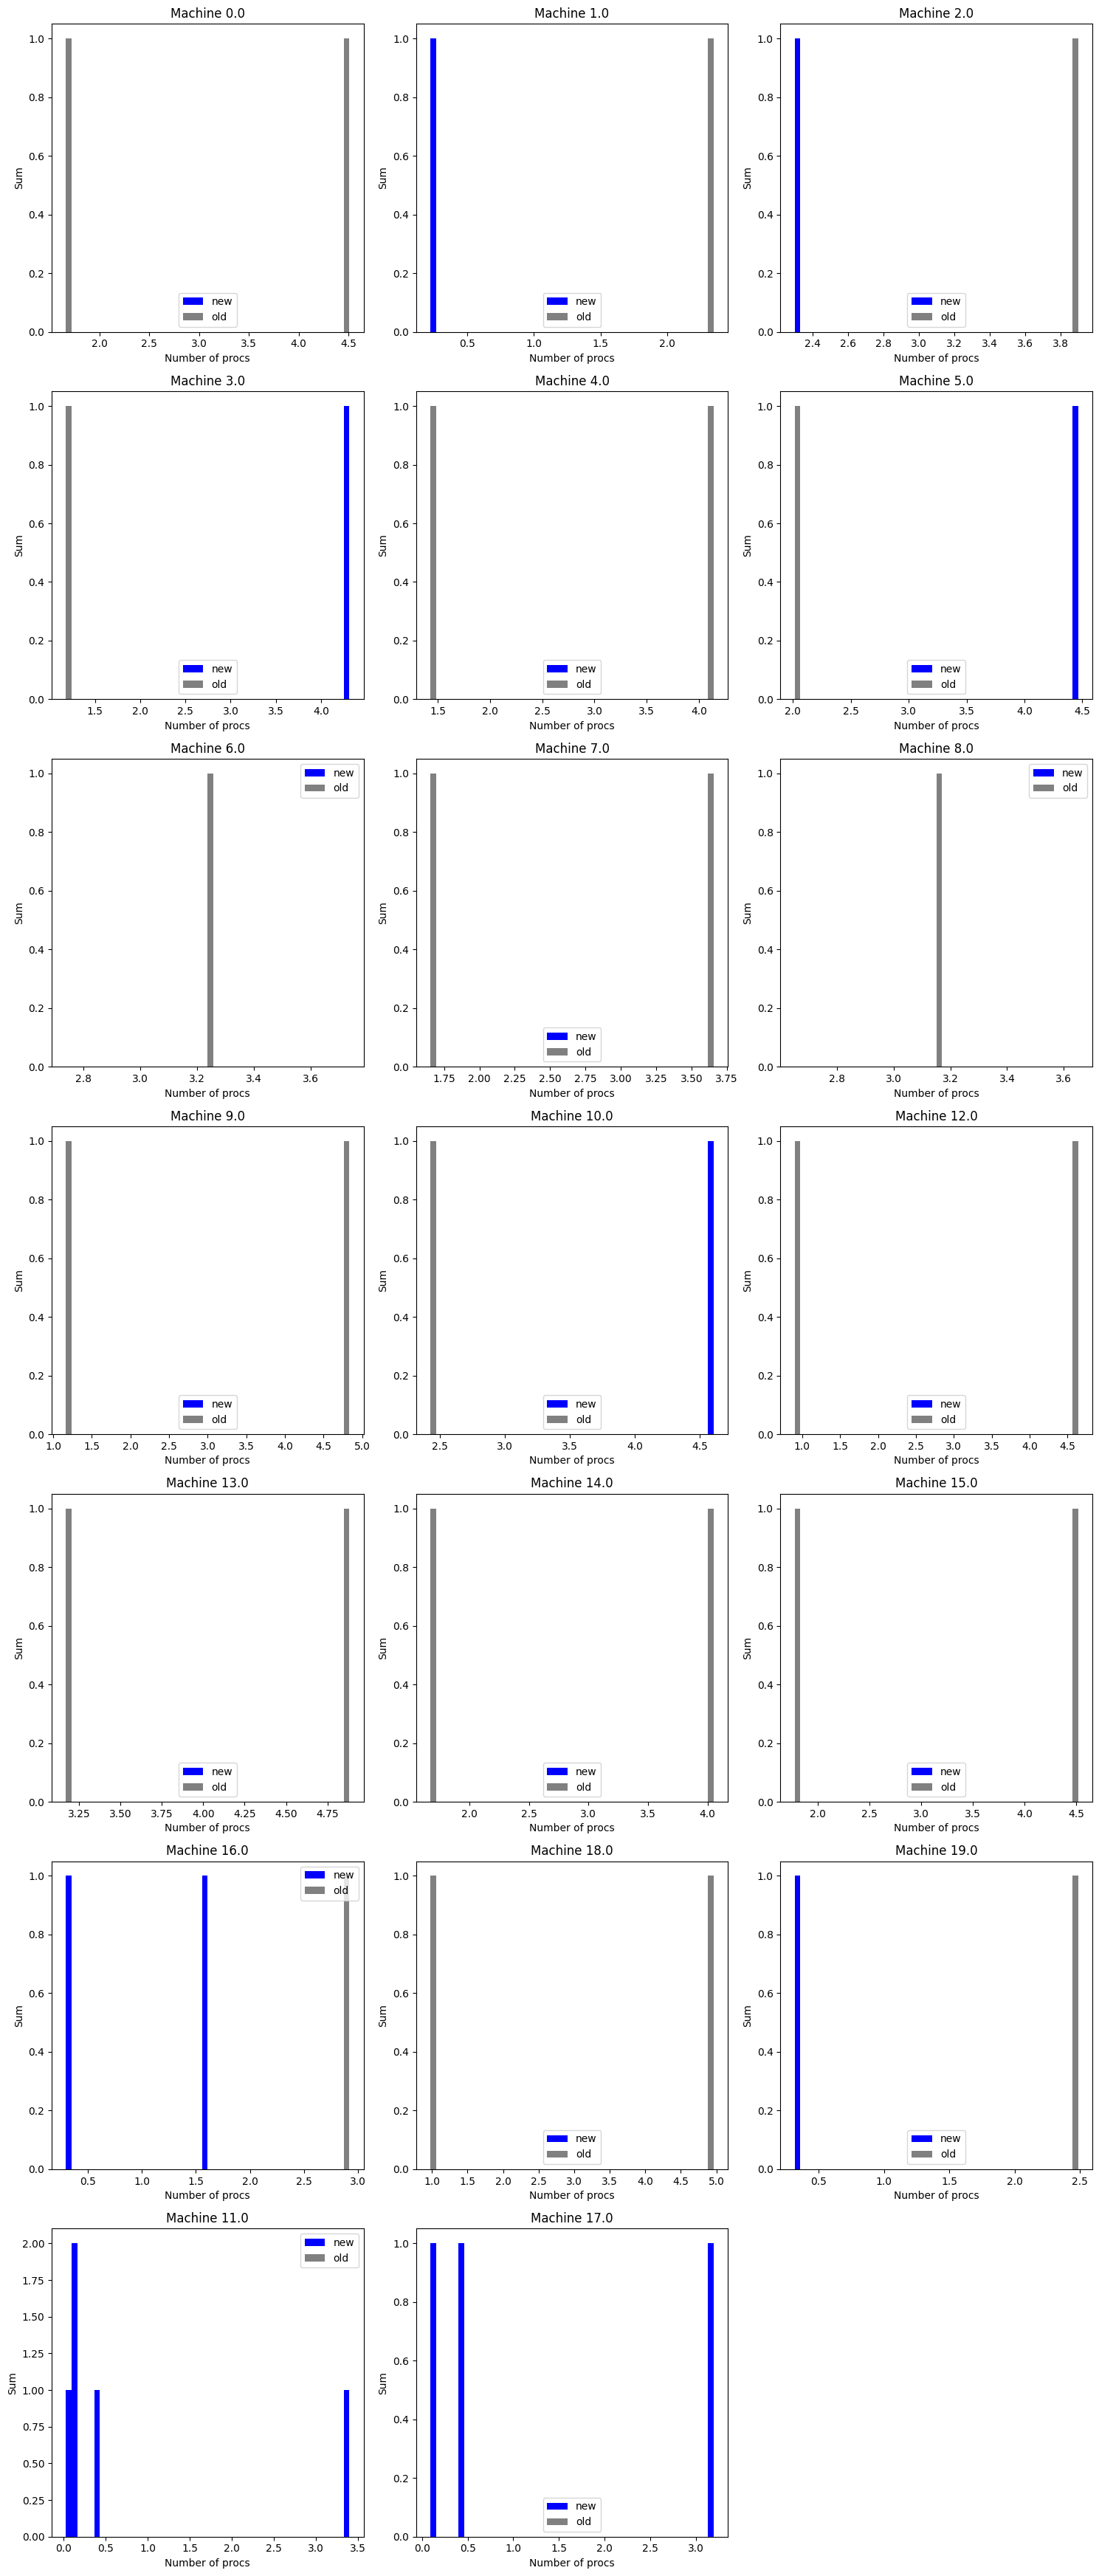

In [271]:
# CDFs of all the procs currently on each machine (looking at diffToSLA)
unique_ids = total_procs['machineID'].unique()

# Set up subplots
num_plots = len(unique_ids)
num_cols = 3  # Adjust as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

# Plot each machine's data
for i, id_ in enumerate(unique_ids):
    ax = axes[i]
    all_procs = total_procs.where((total_procs['machineID']==id_)).dropna().reset_index(drop=True)

    new_data = all_procs.where((all_procs['isNew']==True)).dropna().reset_index(drop=True)
    old_data = all_procs.where((all_procs['isNew']==False)).dropna().reset_index(drop=True)

    # Plotting
    ax.hist([new_data["diffToSla"], old_data["diffToSla"]],
            bins=50, stacked=True,
            color=['blue', 'gray'],
            label=['new', 'old'])

    ax.set_title(f'Machine {id_}')
    ax.set_xlabel('Number of procs')
    ax.set_ylabel('Sum')
    ax.legend(prop={'size': 10})

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()